In [ ]:
import torch
from torchinfo import summary
from tqdm import tqdm
import TorchData
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
import importlib
importlib.reload(TorchData)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [ ]:
NUM_DATA = 1024
BATCH_SIZE = 256
EPOCH = 100

In [ ]:
train_dataset = TorchData.TORCHDataset2Channel(num_data=NUM_DATA)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
test_dataset = TorchData.TORCHDataset2Channel(num_data=1024)
test_dataloader = test_dataset.dataloader(batch_size=256, shuffle=False)

In [ ]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 2, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
summary(model, input_size=(1, 2, 120, 92))

In [ ]:
for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()
        outputs = model(x.to(device))
        loss = loss_function(outputs, y.to(device))
        loss.backward()
        optimiser.step()

In [ ]:
torch.save(model.state_dict(), f"Conv2Channel_{NUM_DATA}_{BATCH_SIZE}_{EPOCH}.pth")

In [102]:
### Using pretrained weights
model.load_state_dict(torch.load("ModelWeights/Conv2Channel/Conv2Channel_5096_512_3000.pth", weights_only=True))

<All keys matched successfully>

In [108]:
model.eval()
with torch.no_grad():
    all_pred = model.to("cpu")(test_dataset.x.to("cpu"))

all_pred_binary = all_pred[:, 0].unsqueeze(1)
all_pred_binary /= all_pred_binary.max()
all_pred_binary = torch.where(all_pred_binary < 0.5, 0, 1)
all_pred_time = all_pred[:, 1].unsqueeze(1) * test_dataset.sn_time.squeeze(0)
all_pred_time[all_pred_time < 0.5] = 0
all_pred_combined = all_pred_binary * all_pred_time

Text(0.5, 0.92, 'Combined Image')

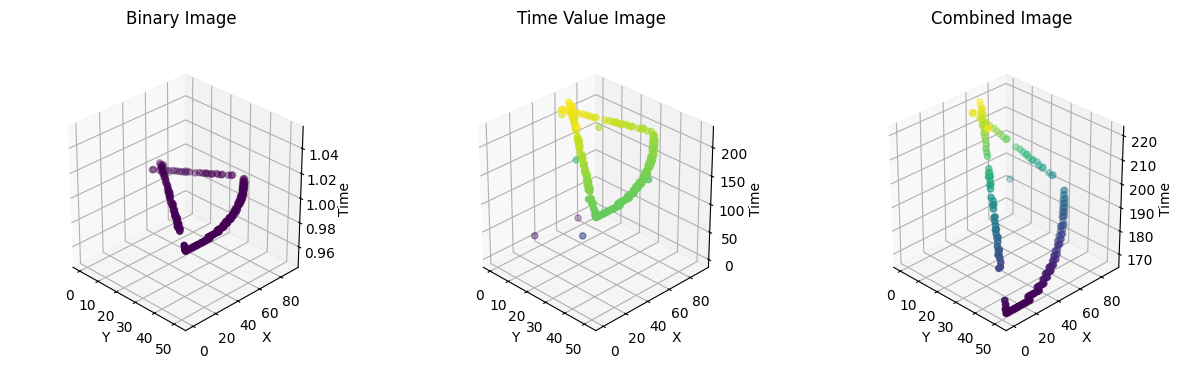

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
TorchData.visual.plot3d(all_pred_binary[0], ax[0])
ax[0].set_title("Binary Image")
TorchData.visual.plot3d(all_pred_time[0], ax[1])
ax[1].set_title("Time Value Image")
TorchData.visual.plot3d(all_pred_combined[0], ax[2])
ax[2].set_title("Combined Image")

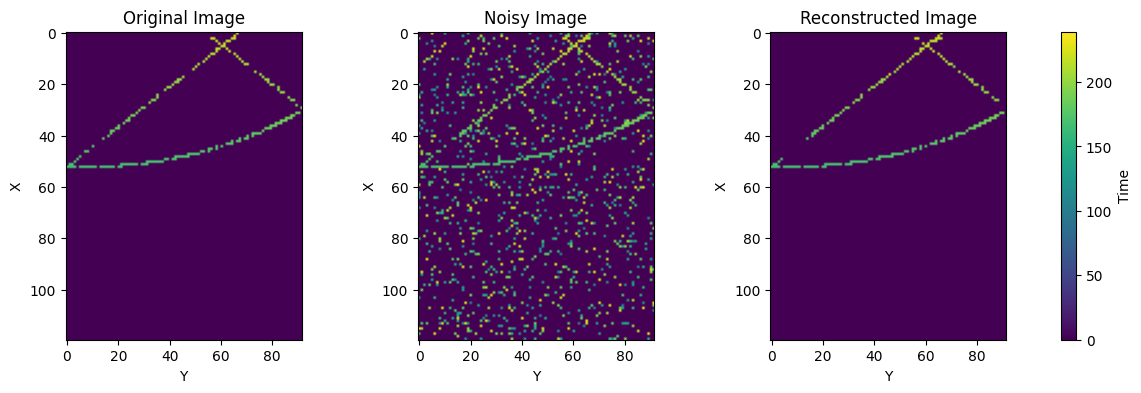

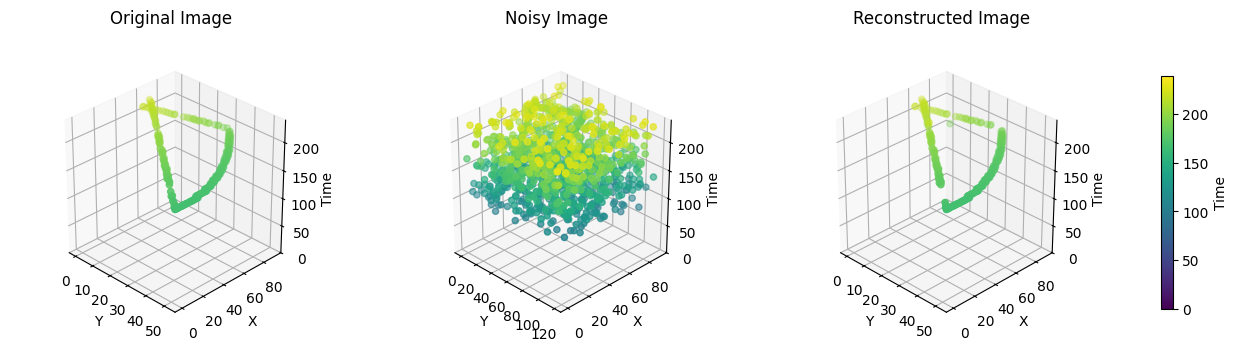

In [105]:
TorchData.visual.fast_compare_plot(test_dataset, all_pred_combined, 0)

In [114]:
pred_list = [
    {"name": "Time Value Image", "data": all_pred_time},
    {"name": "Combined Image", "data": all_pred_combined}
]
for i in pred_list:
    print(f"Metrics for {i['name']}:")
    mse = TorchData.metric.calculate_mse_torch(test_dataset.signal_time, i["data"])
    psnr = TorchData.metric.calculate_psnr_torch(test_dataset.signal_time, i["data"])
    ssim = TorchData.metric.calculate_ssim_torch(test_dataset.signal_time, i["data"])
    roc_auc = roc_auc_score(test_dataset.signal.flatten().numpy(), i["data"].flatten().numpy())
    print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, ROC AUC: {roc_auc:.4f}")

Metrics for Time Value Image
MSE: 40.8420, PSNR: 30.7374, SSIM: 0.9709, ROC AUC: 0.9991
Metrics for Combined Image
MSE: 21.2011, PSNR: 33.5849, SSIM: 0.9878, ROC AUC: 0.9973


In [152]:
model2 = ConvolutionAutoencoder().to(device)
optimiser2 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [147]:
train_dataset2 = TorchData.TORCHDataset2Channel(num_data=1024)
train_dataset2.x = torch.cat((all_pred_binary, all_pred_time), dim=1)
train_dataset2.y = test_dataset.y
train_dataloader2 = train_dataset2.dataloader(batch_size=256, shuffle=True)

In [153]:
for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader2:
        optimiser2.zero_grad()
        outputs = model2(x.to(device))
        loss = loss_function(outputs, y.to(device))
        loss.backward()
        optimiser2.step()

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [154]:
torch.save(model2.state_dict(), f"Conv2Channel_secondary_{NUM_DATA}_{BATCH_SIZE}_{EPOCH}.pth")

In [155]:
model2.load_state_dict(torch.load(f"Conv2Channel_secondary_{NUM_DATA}_{BATCH_SIZE}_{EPOCH}.pth", weights_only=True))

<All keys matched successfully>

In [156]:
test_dataset2 = TorchData.TORCHDataset2Channel(num_data=1024)
test_dataloader2 = test_dataset2.dataloader(batch_size=256, shuffle=False)

In [157]:
model.eval()
with torch.no_grad():
    all_pred2_1 = model.to("cpu")(test_dataset2.x.to("cpu"))

all_pred_binary2_1 = all_pred2_1[:, 0].unsqueeze(1)
all_pred_binary2_1 /= all_pred_binary2_1.max()
all_pred_binary2_1 = torch.where(all_pred_binary2_1 < 0.5, 0, 1)
all_pred_time2_1 = all_pred2_1[:, 1].unsqueeze(1) * test_dataset2.sn_time.squeeze(0)
all_pred_time2_1[all_pred_time2_1 < 0.5] = 0
all_pred_combined2_1 = all_pred_binary2_1 * all_pred_time2_1

In [158]:
torch.cat((all_pred_binary2_1, all_pred_time2_1), dim=1).shape

torch.Size([1024, 2, 120, 92])

In [159]:
model2.eval()
with torch.no_grad():
    x = torch.cat((all_pred_binary2_1, all_pred_time2_1), dim=1)
    all_pred2 = model2.to("cpu")(x.to("cpu"))

all_pred_binary2 = all_pred2[:, 0].unsqueeze(1)
all_pred_binary2 /= all_pred_binary2.max()
all_pred_binary2 = torch.where(all_pred_binary2 < 0.5, 0, 1)
all_pred_time2 = all_pred2[:, 1].unsqueeze(1) * all_pred_combined2_1.squeeze(0)
all_pred_time2[all_pred_time2 < 0.5] = 0
all_pred_combined2 = all_pred_binary2 * all_pred_time2

Text(0.5, 0.92, 'Combined Image')

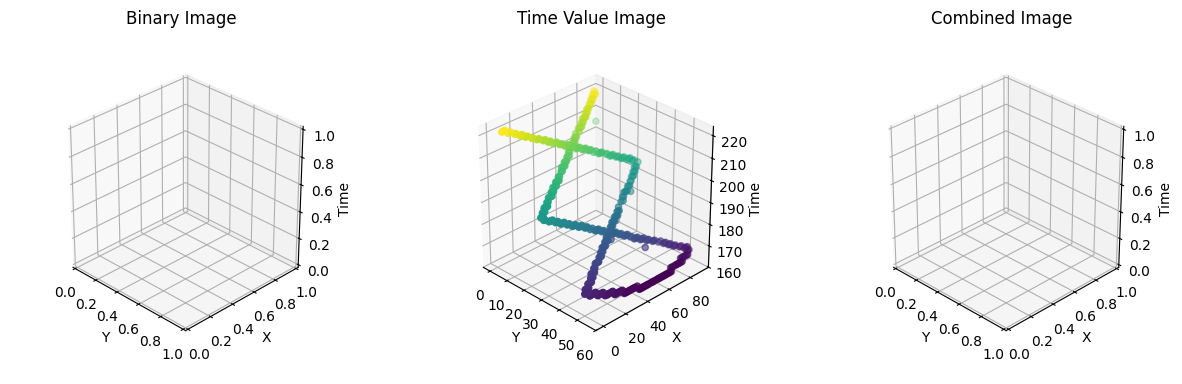

In [160]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
TorchData.visual.plot3d(all_pred_binary2[0], ax[0])
ax[0].set_title("Binary Image")
TorchData.visual.plot3d(all_pred_time2[0], ax[1])
ax[1].set_title("Time Value Image")
TorchData.visual.plot3d(all_pred_combined2[0], ax[2])
ax[2].set_title("Combined Image")

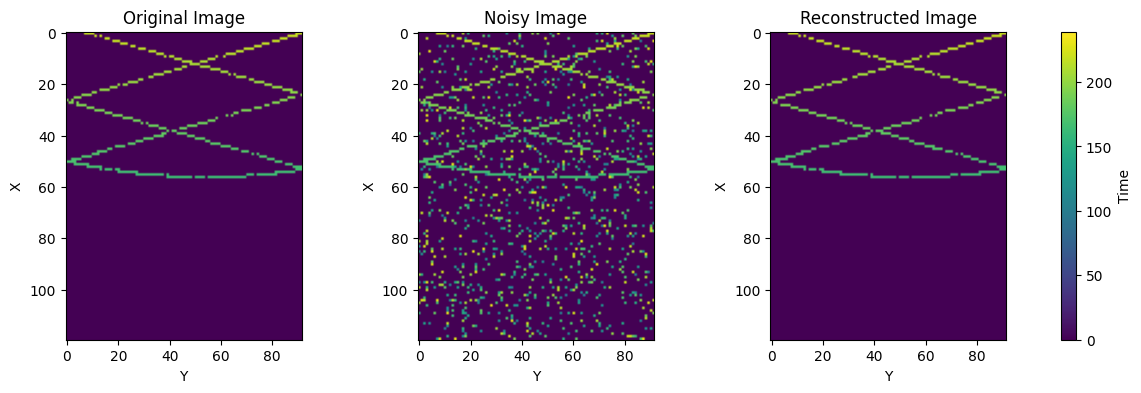

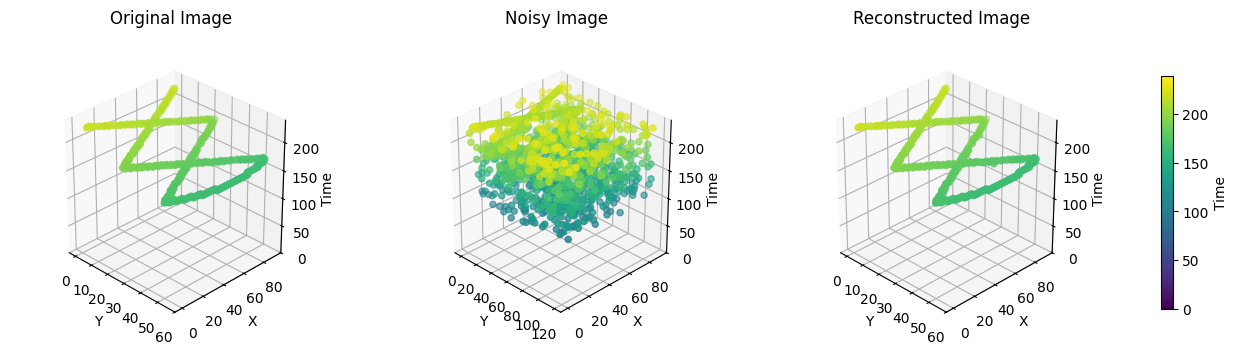

In [167]:
TorchData.visual.fast_compare_plot(test_dataset2, all_pred_time2, 0)

In [164]:
pred_list = [
    {"name": "Time Value Image", "data": all_pred_time2},
    {"name": "Combined Image", "data": all_pred_combined2}
]
for i in pred_list:
    print(f"Metrics for {i['name']}:")
    mse = TorchData.metric.calculate_mse_torch(test_dataset2.signal_time, i["data"])
    psnr = TorchData.metric.calculate_psnr_torch(test_dataset2.signal_time, i["data"])
    ssim = TorchData.metric.calculate_ssim_torch(test_dataset2.signal_time, i["data"])
    roc_auc = roc_auc_score(test_dataset2.signal.flatten().numpy(), i["data"].flatten().numpy())
    print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, ROC AUC: {roc_auc:.4f}")

Metrics for Time Value Image:
MSE: 20.8129, PSNR: 33.6651, SSIM: 0.9875, ROC AUC: 0.9972
Metrics for Combined Image:
MSE: 1087.8459, PSNR: 16.4828, SSIM: 0.5986, ROC AUC: 0.5000


In [168]:
pred_list = [
    {"name": "Time Value Image", "data": all_pred_time2_1},
    {"name": "Combined Image", "data": all_pred_combined2_1}
]
for i in pred_list:
    print(f"Metrics for {i['name']}:")
    mse = TorchData.metric.calculate_mse_torch(test_dataset2.signal_time, i["data"])
    psnr = TorchData.metric.calculate_psnr_torch(test_dataset2.signal_time, i["data"])
    ssim = TorchData.metric.calculate_ssim_torch(test_dataset2.signal_time, i["data"])
    roc_auc = roc_auc_score(test_dataset2.signal.flatten().numpy(), i["data"].flatten().numpy())
    print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, ROC AUC: {roc_auc:.4f}")

Metrics for Time Value Image:
MSE: 40.6316, PSNR: 30.7598, SSIM: 0.9707, ROC AUC: 0.9992
Metrics for Combined Image:
MSE: 20.8316, PSNR: 33.6612, SSIM: 0.9875, ROC AUC: 0.9972
